# import package



In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from pytorch_logit_logic import actfun_name2factory
from torch import nn
import os
from tqdm import tqdm
from torchsummary import summary 

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Set different Path

In [16]:
batch_size = 256
epochs = 10
save_max_path = '/content/MLP_model/max_model.ckpt'
save_ail_or_path = '/content/MLP_model/ail_or_model.ckpt'
save_nail_or_path = '/content/MLP_model/nail_or_model.ckpt'
save_ReLU_path = '/content/MLP_model/ReLUmodel.ckpt'
save_ail_xnor_path = '/content/MLP_model/ail_xnor_model.ckpt'
save_ail_or_xnor_dup_path = '/content/MLP_model/ail_or_xnor_dup_model.ckpt'

## Build Model

In [17]:
class MLP(nn.Module):
    def __init__(self,in_channels,out_channels,n_layer=1,hidden_width=None,actfun="ReLU",actfun_k=None):
        super().__init__()
        # Create a factory that generates objects that perform this activation
        actfun_factory = actfun_name2factory(actfun, k=actfun_k)
        _actfun = actfun_factory()
        divisor = getattr(_actfun, "k", 1)
        feature_factor = getattr(_actfun, "feature_factor", 1)

        if hidden_width is None:
            hidden_width = in_channels

        # Ensure the hidden width is divisible by the divisor
        hidden_width = int(int(round(hidden_width / divisor)) * divisor)

        layers = []
        n_current = in_channels
        for i_layer in range(0, n_layer):
            layer = []
            layer.append(nn.Linear(n_current, hidden_width))
            n_current = hidden_width
            layer.append(actfun_factory())
            n_current = int(round(n_current * feature_factor))
            layers.append(nn.Sequential(*layer))
        self.layers = nn.Sequential(*layers)
        self.classifier = nn.Linear(n_current, out_channels)

    def forward(self, x):
        x = self.layers(x)
        x = self.classifier(x)
        return x

## Train

In [18]:
def train(train_loader, valid_loader, model, path):
  best_loss = float('inf')
  criterion = nn.CrossEntropyLoss() 
  optimizer = torch.optim.Adam(model.parameters())
  if not os.path.isdir('/content/MLP_model'):
    os.mkdir('/content/MLP_model')

  train_loss_record = []
  valid_loss_record = []
  train_loss_record_epoch = []
  valid_loss_record_epoch = []
  accs = []
  for epoch in range(epochs):
    model.train()      
    train_bar = tqdm(trainloader, position = 0, leave = True)
    for x, y in train_bar:
      optimizer.zero_grad()       
      pred = model(x.flatten(start_dim=1))
      loss = criterion(pred, y)
      loss.backward()           
      optimizer.step()          
      train_loss_record.append(loss.detach().item())
      
      # display current epoch
      train_bar.set_description(f'Epoch[{epoch+1}/{epochs}]')
      train_bar.set_postfix({'loss': loss.detach().item()})
        
    mean_train_loss = sum(train_loss_record) / len(train_loss_record)
    train_loss_record_epoch.append(mean_train_loss)
    model.eval()
    for x, y in validloader:
      with torch.no_grad():
          pred = model(x.flatten(start_dim=1))
          loss = criterion(pred, y)
      valid_loss_record.append(loss)
    mean_valid_loss = sum(valid_loss_record) / len(valid_loss_record)
    valid_loss_record_epoch.append(mean_valid_loss)

    acc = 0
    length = 0

    for x, y in tqdm(testloader):    
        length += len(y)                
        with torch.no_grad():
            pred = model(x.flatten(start_dim=1))               
            _, val_pred = torch.max(pred, 1)
            acc += torch.sum(val_pred == y)
    
    accs.append(acc/length)
    if epoch%5 == 0:
      print(f'Epoch [{epoch+1}/{epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
    
    if mean_valid_loss < best_loss:
      best_loss = mean_valid_loss
      torch.save(model.state_dict(), path)
  return train_loss_record_epoch, valid_loss_record_epoch, accs

## Evaluate

In [19]:
def evaluate(model_name, save_path, testloader):
  model = MLP(in_channels=784, out_channels=10, n_layer=2,actfun=model_name)
  model.load_state_dict(torch.load(save_path))
  model.eval() # Set your model to evaluation mode.
  acc = 0
  length = 0

  for x, y in tqdm(testloader):    
      length += len(y)                
      with torch.no_grad():
          # print(y)
          pred = model(x.flatten(start_dim=1))               
          _, val_pred = torch.max(pred, 1)
          # print(val_pred)
          acc += torch.sum(val_pred == y)
  
  return acc/length

## Load Data

In [20]:
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_len = int(len(train_set)*0.7)
valid_len = len(train_set) - train_len
train_set, valid_set = data.random_split(train_set, [train_len, valid_len])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(train_set), len(valid_set), len(test_set))

42000 18000 10000


## Build 6 models

In [21]:
nail_or_model = MLP(in_channels=784, out_channels=10, n_layer=2,actfun="nail_or")
ail_xnor_model = MLP(in_channels=784, out_channels=10, n_layer=2,actfun="ail_xnor")
ReLU_model = MLP(in_channels=784, out_channels=10, n_layer=2, actfun='ReLU')

max_model = MLP(in_channels=784, out_channels=10, n_layer=2,actfun="max")
ail_or_model = MLP(in_channels=784, out_channels=10, n_layer=2,actfun="ail_or")
ail_or_xnor_dup_model = MLP(in_channels=784, out_channels=10, n_layer=2, actfun = 'ail_or_xnor_dup')

## Show the model summary

In [27]:
batch_size = 512
summary(ReLU_model, input_size=(batch_size, 1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1          [-1, 512, 1, 784]         615,440
              ReLU-2          [-1, 512, 1, 784]               0
            Linear-3          [-1, 512, 1, 784]         615,440
              ReLU-4          [-1, 512, 1, 784]               0
            Linear-5           [-1, 512, 1, 10]           7,850
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.53
Forward/backward pass size (MB): 12.29
Params size (MB): 4.73
Estimated Total Size (MB): 18.55
----------------------------------------------------------------


In [64]:
train_loss_nail_or, valid_loss_nail_or, accs_nail_or = train(trainloader, validloader, nail_or_model, save_nail_or_path)
train_loss_ail_xnor, valid_loss_ail_xnor, accs_ail_xnor = train(trainloader, validloader, ail_xnor_model, save_ail_xnor_path)
train_loss_ReLU, valid_loss_ReLU, accs_ReLU = train(trainloader, validloader, ReLU_model, save_ReLU_path)
train_loss_max, valid_loss_max, accs_max = train(trainloader, validloader, max_model, save_max_path)
train_loss_ail_or, valid_loss_ail_or, accs_ail_or = train(trainloader, validloader, ail_or_model, save_ail_or_path)
train_loss_ail_or_xnor_dup, valid_loss_ail_or_xnor_dup, accs_ail_or_xnor_dup = train(trainloader, validloader, ail_or_xnor_dup_model, save_ail_or_xnor_dup_path)

100%|██████████| 40/40 [00:02<00:00, 14.33it/s]


Epoch [1/10]: Train loss: 0.3634, Valid loss: 0.1792


100%|██████████| 40/40 [00:01<00:00, 21.34it/s]


Epoch [6/10]: Train loss: 0.1199, Valid loss: 0.1195


100%|██████████| 40/40 [00:01<00:00, 22.32it/s]


Epoch [1/10]: Train loss: 0.3226, Valid loss: 0.1345


100%|██████████| 40/40 [00:01<00:00, 22.32it/s]


Epoch [6/10]: Train loss: 0.0917, Valid loss: 0.0994


100%|██████████| 40/40 [00:01<00:00, 22.95it/s]


Epoch [1/10]: Train loss: 0.3591, Valid loss: 0.1904


100%|██████████| 40/40 [00:01<00:00, 20.24it/s]


Epoch [6/10]: Train loss: 0.1141, Valid loss: 0.1133


100%|██████████| 40/40 [00:01<00:00, 23.09it/s]


Epoch [1/10]: Train loss: 0.3279, Valid loss: 0.1456


100%|██████████| 40/40 [00:01<00:00, 23.24it/s]


Epoch [6/10]: Train loss: 0.0997, Valid loss: 0.1134


100%|██████████| 40/40 [00:01<00:00, 22.09it/s]


Epoch [1/10]: Train loss: 0.3293, Valid loss: 0.1767


100%|██████████| 40/40 [00:02<00:00, 17.27it/s]


Epoch [6/10]: Train loss: 0.1073, Valid loss: 0.1158


100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


Epoch [1/10]: Train loss: 0.2763, Valid loss: 0.1179


100%|██████████| 40/40 [00:02<00:00, 19.88it/s]


Epoch [6/10]: Train loss: 0.0880, Valid loss: 0.1140


100%|██████████| 40/40 [00:02<00:00, 19.72it/s]


## Comparison

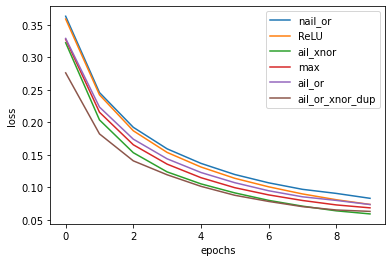

In [65]:
fig, ax = plt.subplots()
x_epoch = np.arange(len(train_loss_nail_or))
ax.plot(x_epoch, train_loss_nail_or, label = 'nail_or')
ax.plot(x_epoch, train_loss_ReLU, label = 'ReLU')
ax.plot(x_epoch, train_loss_ail_xnor, label = 'ail_xnor')

ax.plot(x_epoch, train_loss_max, label = 'max')
ax.plot(x_epoch, train_loss_ail_or, label = 'ail_or')
ax.plot(x_epoch, train_loss_ail_or_xnor_dup, label = 'ail_or_xnor_dup')

ax.set_xlabel('epochs') 
ax.set_ylabel('loss')
ax.legend() 
plt.show() 

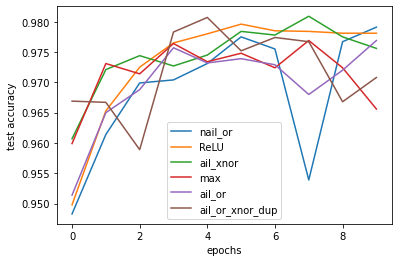

In [67]:
fig, ax = plt.subplots()
x_epoch = np.arange(len(accs_ReLU))
ax.plot(x_epoch, accs_nail_or, label = 'nail_or')
ax.plot(x_epoch, accs_ReLU, label = 'ReLU')
ax.plot(x_epoch, accs_ail_xnor, label = 'ail_xnor')

ax.plot(x_epoch, accs_max, label = 'max')
ax.plot(x_epoch, accs_ail_or, label = 'ail_or')
ax.plot(x_epoch, accs_ail_or_xnor_dup, label = 'ail_or_xnor_dup')
ax.set_xlabel('epochs') 
ax.set_ylabel('test accuracy')
ax.legend() 
plt.show() 

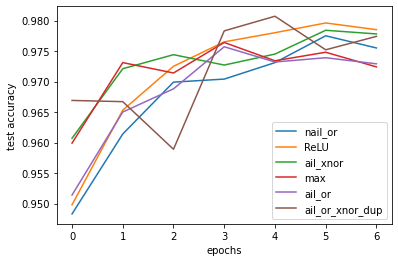

In [69]:
fig, ax = plt.subplots()
x_epoch = np.arange(7)
ax.plot(x_epoch, accs_nail_or[:7], label = 'nail_or')
ax.plot(x_epoch, accs_ReLU[:7], label = 'ReLU')
ax.plot(x_epoch, accs_ail_xnor[:7], label = 'ail_xnor')

ax.plot(x_epoch, accs_max[:7], label = 'max')
ax.plot(x_epoch, accs_ail_or[:7], label = 'ail_or')
ax.plot(x_epoch, accs_ail_or_xnor_dup[:7], label = 'ail_or_xnor_dup')
ax.set_xlabel('epochs') 
ax.set_ylabel('test accuracy')
ax.legend() 
plt.show() 